# Randomized Optimization (Neural Network's weights Optimization)

Author: Richard Huang

Fall 2020

In [1]:
import time
import numpy as np 
import pandas as pd

from numpy.random import seed

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss

import mlrose_hiive2

In [2]:
INPUT_DATA = 'bank_marketing_data/'
TRAIN_CSV = 'bank.csv'

GRAPHS_PATH = "graphs/"

RANDOM_STATE = 17

In [3]:
# Hyper-parameters
HIDDEN_NODES = [32, 16]
NB_ITERATIONS = 4000

# Data Pre-processing

In [4]:
train_csv = pd.read_csv(INPUT_DATA+TRAIN_CSV)
print(train_csv.shape)
train_csv.head()

(11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [5]:
features = [col for col in train_csv.columns if col not in ['deposit']]
print(len(features))

16


In [6]:
train_csv['deposit'] = train_csv['deposit'].replace({'no': 0, 'yes':1}).astype(int)
target_values = train_csv['deposit'].values
print(len(target_values))

11162


## Label encoding

In [7]:
non_numerical_features = list(set(features) - set(train_csv._get_numeric_data().columns))
non_num_csv = train_csv[non_numerical_features]
print(non_num_csv.shape)
non_num_csv.head()

(11162, 9)


,contact,job,poutcome,loan,marital,default,housing,education,month
0,unknown,admin.,unknown,no,married,no,yes,secondary,may
1,unknown,admin.,unknown,no,married,no,no,secondary,may
2,unknown,technician,unknown,no,married,no,yes,secondary,may
3,unknown,services,unknown,no,married,no,yes,secondary,may
4,unknown,admin.,unknown,no,married,no,no,tertiary,may


In [8]:
for col in non_numerical_features:
    print(set(non_num_csv[col]))

{'telephone', 'cellular', 'unknown'}
{'retired', 'housemaid', 'student', 'blue-collar', 'technician', 'unemployed', 'self-employed', 'entrepreneur', 'management', 'services', 'unknown', 'admin.'}
{'failure', 'unknown', 'success', 'other'}
{'yes', 'no'}
{'single', 'married', 'divorced'}
{'yes', 'no'}
{'yes', 'no'}
{'secondary', 'tertiary', 'unknown', 'primary'}
{'aug', 'oct', 'sep', 'may', 'jul', 'dec', 'jun', 'apr', 'nov', 'feb', 'jan', 'mar'}


For the columns 'default', 'housing' and 'loan', since we have some yes and no values, we have to attribute no to 0 and yes to 1.
For the others, we can encode the labels as usual.

In [9]:
yes_no_columns = ['default', 'housing', 'loan']
yes_no_features = [x for x in non_numerical_features if x in yes_no_columns]
train_csv[yes_no_features] = train_csv[yes_no_features].replace({'no': 0, 'yes':1}).astype(int)
train_csv[non_numerical_features].head()

,contact,job,poutcome,loan,marital,default,housing,education,month
0,unknown,admin.,unknown,0,married,0,1,secondary,may
1,unknown,admin.,unknown,0,married,0,0,secondary,may
2,unknown,technician,unknown,0,married,0,1,secondary,may
3,unknown,services,unknown,0,married,0,1,secondary,may
4,unknown,admin.,unknown,0,married,0,0,tertiary,may


In [10]:
other_columns = [col for col in non_numerical_features if col not in yes_no_columns]
for col in other_columns:
    label_encod = LabelEncoder()
    label_encod.fit(list(train_csv[col].values))
    train_csv[col] = label_encod.transform(train_csv[col].astype(str))

train_csv[non_numerical_features].head()

,contact,job,poutcome,loan,marital,default,housing,education,month
0,2,0,3,0,1,0,1,1,8
1,2,0,3,0,1,0,0,1,8
2,2,9,3,0,1,0,1,1,8
3,2,7,3,0,1,0,1,1,8
4,2,0,3,0,1,0,0,2,8


### Check NaN values

In [11]:
nan_array = train_csv.isnull().sum().values/train_csv.shape[0]*100
df_nan = pd.DataFrame(nan_array, columns=['Count'], index=train_csv.columns)
df_nan = df_nan.sort_values(by=['Count'], ascending=False)
counter_nan = df_nan[df_nan['Count']>0].shape[0]

print(f'{counter_nan} rows have nan values.')
df_nan.head(10)

0 rows have nan values.


,Count
age,0.0
day,0.0
poutcome,0.0
previous,0.0
pdays,0.0
campaign,0.0
duration,0.0
month,0.0
contact,0.0
job,0.0


## Scale and change dtype

In [12]:
threshold_cate = 25

col_continuous = []
col_categorical = []

for col in features:
    new_col = sorted(list(set(train_csv[col])))
    #print()
    #print(col)
    #print(new_col)
    min_col = np.min(new_col)
    max_col = np.max(new_col)

    if max_col > threshold_cate or col in ['age']:
        col_continuous.append(col)
        continue

    col_categorical.append(col)

In [13]:
train_csv[col_continuous]

,age,balance,day,duration,campaign,pdays,previous
0,59,2343,5,1042,1,-1,0
1,56,45,5,1467,1,-1,0
2,41,1270,5,1389,1,-1,0
3,55,2476,5,579,1,-1,0
4,54,184,5,673,2,-1,0
...,...,...,...,...,...,...,...
11157,33,1,20,257,1,-1,0
11158,39,733,16,83,4,-1,0
11159,32,29,19,156,2,-1,0
11160,43,0,8,9,2,172,5


In [14]:
scaler = StandardScaler()
data2scale = train_csv[col_continuous]
scaler.fit(data2scale)
scaled_cols = scaler.transform(data2scale)
train_csv[col_continuous] = scaled_cols

In [15]:
# Put as int
train_csv[col_categorical] = train_csv[col_categorical].astype('int')

In [16]:
train_csv.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,1.491505,0,1,1,0,0.252525,1,0,2,-1.265746,8,1.930226,-0.554168,-0.481184,-0.36326,3,1
1,1.239676,0,1,1,0,-0.459974,0,0,2,-1.265746,8,3.154612,-0.554168,-0.481184,-0.36326,3,1
2,-0.019470,9,1,1,0,-0.080160,1,0,2,-1.265746,8,2.929901,-0.554168,-0.481184,-0.36326,3,1
3,1.155733,7,1,1,0,0.293762,1,0,2,-1.265746,8,0.596366,-0.554168,-0.481184,-0.36326,3,1
4,1.071790,0,1,2,0,-0.416876,0,0,2,-1.265746,8,0.867171,-0.186785,-0.481184,-0.36326,3,1


## Splitting the data

TODO: 
- Implement Stratified KFold: https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold
- Compare classical Stratified split with Stratified KFold split

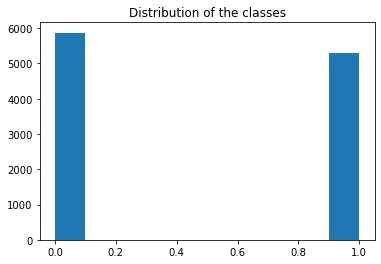

In [17]:
plt.title("Distribution of the classes")
plt.hist(train_csv[['deposit']].values)
plt.show()

In [18]:
training_df, test_df = train_test_split(train_csv, test_size=0.2, random_state=RANDOM_STATE, stratify=train_csv[['deposit']])
train_df, val_df = train_test_split(training_df, test_size=0.2, random_state=RANDOM_STATE, stratify=training_df[['deposit']])

print("Train set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)
print("Test set shape:", test_df.shape)

Train set shape: (7143, 17)
Validation set shape: (1786, 17)
Test set shape: (2233, 17)


In [19]:
x_training = np.array(training_df[features])
y_training = np.array(training_df['deposit'])

x_train = np.array(train_df[features])
y_train = np.array(train_df['deposit'])

x_val = np.array(val_df[features])
y_val = np.array(val_df['deposit'])

x_test = np.array(test_df[features])
y_test = np.array(test_df['deposit'])

<a id='6'></a>
# Neural Network 

## Backpropagation

In [20]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

### Dataloader for Pytorch

In [21]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, trn_X, trn_y):
        self.trn_X = trn_X
        self.trn_y = trn_y

    def __len__(self):
        return self.trn_X.shape[0]

    def __getitem__(self, idx):
        return self.trn_X[idx,:], self.trn_y[idx]
    
class ValidDataset(torch.utils.data.Dataset):
    def __init__(self, val_X, val_y):
        self.val_X = val_X
        self.val_y = val_y
        
    def __len__(self):
        return self.val_X.shape[0]
        
    def __getitem__(self, idx):
        return self.val_X[idx,:], self.val_y[idx]

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, test_X, test_y):
        self.test_X = test_X
        self.test_y = test_y
        
    def __len__(self):
        return self.test_X.shape[0]

    def __getitem__(self, idx):
        return self.test_X[idx,:], self.test_y[idx]

In [22]:
def create_dataloaders(x_train, y_train, x_val, y_val, x_test, y_test, device, batch_size):
    trn_X, trn_y = torch.tensor(x_train.astype(np.float32)).to(device), torch.tensor(y_train).to(device).long()
    val_X, val_y = torch.tensor(x_val.astype(np.float32)).to(device), torch.tensor(y_val).to(device).long()
    test_X, test_y = torch.tensor(x_test.astype(np.float32)).to(device), torch.tensor(y_test).to(device).long()
    train_set = TrainDataset(trn_X, trn_y)
    val_set = ValidDataset(val_X, val_y)
    test_set = TestDataset(test_X, test_y)
    dataloaders_length = [len(train_set), len(val_set), len(test_set)]

    trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
    validationloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size)
    testloader = torch.utils.data.DataLoader(test_set, batch_size=1)

    dataloaders = {"train": trainloader,
                   "val": validationloader,
                   "test": testloader}

    dataset_sizes = {"train": dataloaders_length[0],
                     "val": dataloaders_length[1],
                     "test": dataloaders_length[2]}

    return (dataloaders, dataset_sizes)

### Training functions for Pytorch

In [23]:
from utils import EarlyStopping, plot_training, plot_cm
from main_training import train_model, test_model

In [24]:
DEVICE = 'cpu'
MODEL_TYPE = "Neural Networks"
SAVING = True

BATCH_SIZE = 8
EPOCHS = 1
LR = 1e-3
EARLYSTOP = False
SCHEDULER = False

In [44]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(len(features), 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 2)
        self.dropout = nn.Dropout(0)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
model = Net2()
print(model)

Net2(
  (fc1): Linear(in_features=16, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)


In [45]:
dataloaders, dataset_sizes = create_dataloaders(x_train, y_train, x_val, y_val, x_test, y_test, 
                                                device=DEVICE, batch_size=BATCH_SIZE)

In [46]:
%%time
model = Net2()

###  Define loss function and optimizer ### 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Define dictionary for training info
history_training = {'train_loss': [],
                    'val_loss': [],
                    'train_acc': [],
                    'val_acc': [], 
                    'train_ite': [], 
                    'test_ite': []}


### Training ###
model, history_training = train_model(model=model, hist=history_training, criterion=criterion, 
                                      optimizer=optimizer, dataloaders=dataloaders, dataset_sizes=dataset_sizes, 
                                      max_iterations=NB_ITERATIONS, patience_es=15,device=DEVICE)

Wall time: 8min 6s


In [47]:
### Testing ###
history_training = test_model(model=model, hist=history_training, criterion=criterion, 
                              dataloaders=dataloaders, dataset_sizes=dataset_sizes, device=DEVICE)



**TESTING**


Test stats -  Loss: 0.4550 Acc: 79.09%
Inference on Testset complete in 0.7s



In [48]:
train_loss_bp = [x[0] for x in history_training["train_ite"]]
train_acc_bp = [x[1] for x in history_training["train_ite"]]

test_loss_bp = [x[0] for x in history_training["test_ite"]]
test_acc_bp = [x[1] for x in history_training["test_ite"]]

times_bp = [x[2] for x in history_training["train_ite"]]

iterations_bp = np.arange(len(train_loss_bp))*BATCH_SIZE + BATCH_SIZE

## RHC, SA, GA

In [61]:
# Initialize neural network object and fit object

# RHC
nn_model_rhc = mlrose_hiive2.NeuralNetwork(hidden_nodes=HIDDEN_NODES, activation = 'relu',
                                           algorithm = 'random_hill_climb', 
                                           max_iters = NB_ITERATIONS,
                                           bias = True, is_classifier = True, learning_rate = 0.1,
                                           early_stopping = True, clip_max = 1, max_attempts = NB_ITERATIONS,
                                           random_state=RANDOM_STATE, curve = True)

# SA
nn_model_sa = mlrose_hiive2.NeuralNetwork(hidden_nodes=HIDDEN_NODES, activation = 'relu',
                                          algorithm='simulated_annealing', schedule=mlrose_hiive2.ExpDecay(init_temp=1, exp_const=0.05, min_temp=0.001),
                                          max_iters = NB_ITERATIONS,
                                          bias = True, is_classifier = True, learning_rate = 0.1,
                                          early_stopping = True, clip_max = 1, max_attempts = NB_ITERATIONS,
                                          random_state=RANDOM_STATE, curve = True)

# GA
nn_model_ga = mlrose_hiive2.NeuralNetwork(hidden_nodes=HIDDEN_NODES, activation = 'relu',
                                          algorithm = 'genetic_alg', pop_size = 20, mutation_prob = 0.1,
                                          max_iters = NB_ITERATIONS,
                                          bias = True, is_classifier = True, learning_rate = 0.1,
                                          early_stopping = True, clip_max = 1, max_attempts = NB_ITERATIONS,
                                          random_state=RANDOM_STATE, curve = True)

In [62]:
%%time
start_timer = time.time()
nn_model_rhc.fit(x_train, y_train,
                 x_test = x_test, 
                 y_test = y_test)
current_timer = time.time()
print("RHC running time:", current_timer-start_timer)
start_timer = current_timer
nn_model_sa.fit(x_train,y_train,
                x_test = x_test, 
                y_test = y_test)
current_timer = time.time()
print("SA running time:", current_timer-start_timer)
start_timer = current_timer

state_rhc, train_stats_rhc, test_stats_rhc, times_rhc, iterations_rhc = nn_model_rhc.state, nn_model_rhc.train_stats, nn_model_rhc.test_stats, nn_model_rhc.times, nn_model_rhc.iterations
state_sa, train_stats_sa, test_stats_sa, times_sa, iterations_sa = nn_model_sa.state, nn_model_sa.train_stats, nn_model_sa.test_stats, nn_model_sa.times, nn_model_sa.iterations

RHC running time: 161.49520134925842
SA running time: 143.59382033348083
Wall time: 5min 5s


In [63]:
train_loss_rhc = [x[0] for x in train_stats_rhc]
train_loss_sa = [x[0] for x in train_stats_sa]
train_acc_rhc = [x[1] for x in train_stats_rhc]
train_acc_sa = [x[1] for x in train_stats_sa]

test_loss_rhc = [x[0] for x in test_stats_rhc]
test_loss_sa = [x[0] for x in test_stats_sa]
test_acc_rhc = [x[1] for x in test_stats_rhc]
test_acc_sa = [x[1] for x in test_stats_sa]

In [32]:
%%time
start_timer = time.time()
nn_model_ga.fit(x_train,y_train,
                x_test = x_test, 
                y_test = y_test)
state_ga, train_stats_ga, test_stats_ga, times_ga, iterations_ga = nn_model_ga.state, nn_model_ga.train_stats, nn_model_ga.test_stats, nn_model_ga.times, nn_model_ga.iterations
current_timer = time.time()
print("GA running time:", current_timer-start_timer)
start_timer = current_timer

GA running time: 896.895131111145
Wall time: 14min 56s


In [39]:
train_loss_ga = [x[0] for x in train_stats_ga]
train_acc_ga = [x[1] for x in train_stats_ga]

test_loss_ga = [x[0] for x in test_stats_ga]
test_acc_ga = [x[1] for x in test_stats_ga]

# Results

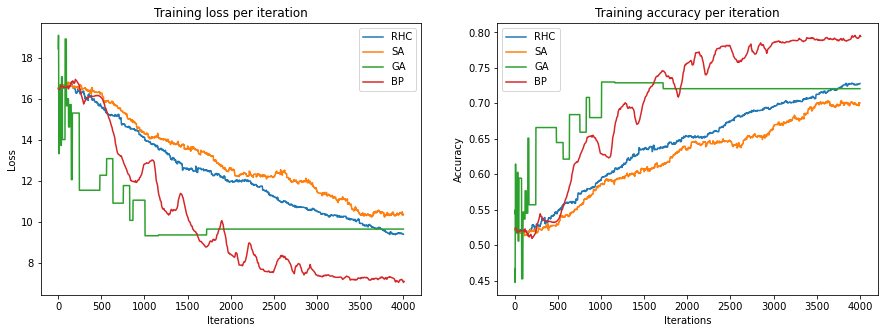

In [64]:
fig=plt.figure(figsize=(15,5))
ax1=fig.add_subplot(1,2,1)
plt.plot(iterations_rhc, train_loss_rhc, label = 'RHC')
plt.plot(iterations_sa, train_loss_sa, label = 'SA')
plt.plot(iterations_ga, train_loss_ga, label = 'GA')
plt.plot(iterations_bp, train_loss_bp, label = 'BP')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training loss per iteration")
ax2=fig.add_subplot(1,2,2)
plt.plot(iterations_rhc, train_acc_rhc, label = 'RHC')
plt.plot(iterations_sa, train_acc_sa, label = 'SA')
plt.plot(iterations_ga, train_acc_ga, label = 'GA')
plt.plot(iterations_bp, train_acc_bp, label = 'BP')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Training accuracy per iteration")
save_graph_path = f"{GRAPHS_PATH}Training_stats.png"
plt.savefig(save_graph_path)
plt.show()

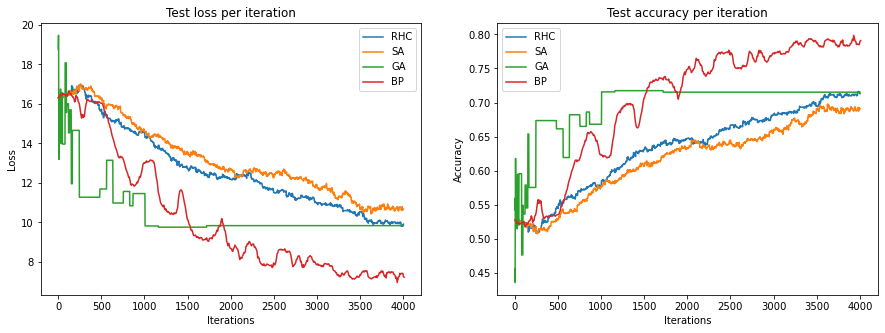

In [65]:
fig=plt.figure(figsize=(15,5))
ax1=fig.add_subplot(1,2,1)
plt.plot(iterations_rhc, test_loss_rhc, label = 'RHC')
plt.plot(iterations_sa, test_loss_sa, label = 'SA')
plt.plot(iterations_ga, test_loss_ga, label = 'GA')
plt.plot(iterations_bp, test_loss_bp, label = 'BP')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Test loss per iteration")
ax2=fig.add_subplot(1,2,2)
plt.plot(iterations_rhc, test_acc_rhc, label = 'RHC')
plt.plot(iterations_sa, test_acc_sa, label = 'SA')
plt.plot(iterations_ga, test_acc_ga, label = 'GA')
plt.plot(iterations_bp, test_acc_bp, label = 'BP')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Test accuracy per iteration")
save_graph_path = f"{GRAPHS_PATH}Test_stats.png"
plt.savefig(save_graph_path)
plt.show()

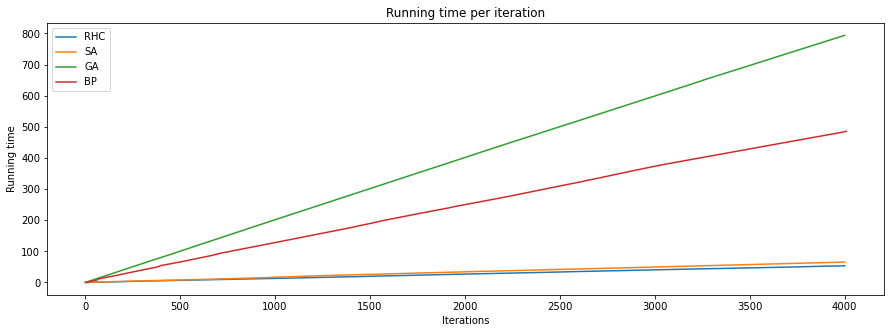

In [66]:
fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(1,1,1)
plt.plot(iterations_rhc,times_rhc, label = 'RHC')
plt.plot(iterations_sa,times_sa, label = 'SA')
plt.plot(iterations_ga,times_ga, label = 'GA')
plt.plot(iterations_bp,times_bp, label = 'BP')
plt.xlabel("Iterations")
plt.ylabel("Running time")
plt.title("Running time per iteration")
plt.legend()
save_graph_path = f"{GRAPHS_PATH}Running_time_stats.png"
plt.savefig(save_graph_path)
plt.show()

In [67]:
for algo, time_list in [('RHC', times_rhc), ('SA', times_sa), ('GA', times_ga), ('BP', times_bp)]:
    print(f"Average running time/iteration for {algo}: {np.mean(time_list)/NB_ITERATIONS} seconds/iteration")

Average running time/iteration for RHC: 0.006697802104040981 seconds/iteration
Average running time/iteration for SA: 0.00847346802679268 seconds/iteration
Average running time/iteration for GA: 0.09999871437864007 seconds/iteration
Average running time/iteration for BP: 0.06237577516768507 seconds/iteration


In [68]:
for algo in ['rhc', 'sa', 'ga', 'bp']:
    train_loss = eval(f'train_loss_{algo}')
    train_acc = eval(f'train_acc_{algo}')
    test_loss = eval(f'test_loss_{algo}')
    test_acc = eval(f'test_acc_{algo}')
    
    print(f"\n{algo}\nbest train_loss: {np.min(train_loss)} | best train_acc: {np.max(train_acc)}")
    print(f"best test_loss: {np.min(test_loss)} | best test_acc: {np.max(test_acc)}")


rhc
best train_loss: 9.375812383725629 | best train_acc: 0.7285454290914182
best test_loss: 9.80646202901229 | best test_acc: 0.716077026421854

sa
best train_loss: 10.231679690625846 | best train_acc: 0.7037659246815063
best test_loss: 10.440628544990116 | best test_acc: 0.6977160770264218

ga
best train_loss: 9.32749331790798 | best train_acc: 0.7299454010919781
best test_loss: 9.760053286540963 | best test_acc: 0.7174205105239588

bp
best train_loss: 7.054855827709759 | best train_acc: 0.7957
best test_loss: 6.960442305332848 | best test_acc: 0.7985
